# Pan005 Bottom Temperature

In [1]:
import gsw
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46695,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:36177,Total threads: 1
Dashboard: /proxy/46139/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41239,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

In [6]:
#Time variant variables
def preprocess(ds):
    ds = ds[['thetao', 'volcello','so']].sel(yh=shelf_mask['yh'])
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

#### Generating temporary files

Control:

In [9]:
start_index=92
n=start_index #Edited because session stopped after file ..._91.nc
for p in pathsC[start_index:]:
    # Open
    cont=xr.open_dataset(p).sel(yh=shelf_mask['yh'])[['thetao', 'volcello','so']]
    cont = cont.load()

    # Calculating pressure
    p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
    
    # Calculating absolute salinity
    SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
    
    # Calculating conservative temperature
    tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])

    # Extract at the bottom
    bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'z_l': -1})))
    bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)
    
    bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='z_l')
    
    bottemp_cont.to_netcdf('/g/data/g40/kc5856/temperature_ssp126/pan005_cont_bottom_temp_'+str(n)+'.nc')
    print('Saved '+str(n))
    n+=1

Saved 92
Saved 93
Saved 94
Saved 95
Saved 96
Saved 97
Saved 98
Saved 99
Saved 100
Saved 101
Saved 102
Saved 103
Saved 104
Saved 105
Saved 106
Saved 107
Saved 108
Saved 109
Saved 110
Saved 111
Saved 112
Saved 113
Saved 114
Saved 115
Saved 116
Saved 117
Saved 118
Saved 119


Meltwater:

In [8]:
start_index=56
n=start_index #Edited because session stopped after file ..._55.nc
for p in pathsM[start_index:]:
    # Open
    melt=xr.open_dataset(p).sel(yh=shelf_mask['yh'])[['thetao', 'volcello','so']]
    melt = melt.load()

    # Calculating pressure
    p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])
    
    # Calculating absolute salinity
    SA_melt = gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])
    
    # Calculating conservative temperature
    tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

    # Extract at the bottom
    bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'z_l': -1})))
    bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

    bottemp_melt = tempM.where(bottom_mask_tempM).sum(dim='z_l')
    
    bottemp_melt.to_netcdf('/g/data/g40/kc5856/temperature_ssp126/pan005_melt_bottom_temp_'+str(n)+'.nc')
    print('Saved '+str(n))
    n+=1

Saved 56
Saved 57
Saved 58
Saved 59


### Opening the loaded data

In [9]:
# Opening files
bottemp_cont = np.sort(glob.glob('/g/data/g40/kc5856/temperature_ssp126/pan005_cont_bottom_temp_*'))
bottemp_melt = np.sort(glob.glob('/g/data/g40/kc5856/temperature_ssp126/pan005_melt_bottom_temp_*'))

In [11]:
bottemp_cont = xr.open_mfdataset(bottemp_cont, concat_dim='time', combine='nested')
bottemp_melt = xr.open_mfdataset(bottemp_melt, concat_dim='time', combine='nested')

In [14]:
bottemp_cont

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 120, yh: 1066, xh: 7200)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2009-04-16 00:00:00
Data variables:
    so       (time, yh, xh) float64 7GB dask.array<chunksize=(1, 1066, 7200), meta=np.ndarray>

In [15]:
bottemp_cont = bottemp_cont.to_array().squeeze()
bottemp_melt = bottemp_melt.to_array().squeeze()

In [16]:
bottemp_cont

<xarray.DataArray (time: 120, yh: 1066, xh: 7200)> Size: 7GB
dask.array<getitem, shape=(120, 1066, 7200), dtype=float64, chunksize=(1, 1066, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh        (xh) float64 58kB -280.0 -279.9 -279.9 ... 79.87 79.92 79.97
  * yh        (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2009-04-16 00:00:00
    variable  <U2 8B 'so'

In [17]:
# To fix the label issues
#bottemp_cont = xr.DataArray(bottemp_cont, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
bottemp_cont.attrs['units'] = '°C'
bottemp_cont.name = 'CT'

#bottemp_melt = xr.DataArray(bottemp_melt, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
bottemp_melt.attrs['units'] = '°C'
bottemp_melt.name = 'CT'

In [25]:
bottemp_cont = bottemp_cont.sortby('time')
bottemp_melt = bottemp_melt.sortby('time')

In [26]:
bottemp_cont

<xarray.DataArray 'CT' (time: 120, yh: 1066, xh: 7200)> Size: 7GB
dask.array<getitem, shape=(120, 1066, 7200), dtype=float64, chunksize=(1, 1066, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh        (xh) float64 58kB -280.0 -279.9 -279.9 ... 79.87 79.92 79.97
  * yh        (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    variable  <U2 8B 'so'
Attributes:
    units:    °C

In [19]:
#Time invariant variables
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

## Mapping

In [27]:
# Taking time mean
bottemp_cont_map = bottemp_cont.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
bottemp_melt_map = bottemp_melt.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [28]:
print(bottemp_cont['time'].values[:5])  # first 5 times
print(bottemp_cont['time'].values[-5:]) # last 5 times

[cftime.DatetimeNoLeap(2001, 1, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 2, 15, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 3, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 4, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 5, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2010, 8, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 9, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 10, 16, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 11, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 12, 16, 12, 0, 0, 0, has_year_zero=True)]


In [29]:
bottemp_anom_map = bottemp_melt_map - bottemp_cont_map
bottemp_anom_map = bottemp_anom_map.load()

2025-07-04 09:32:01,477 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:32795 -> tcp://127.0.0.1:44623
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

Plotting

In [30]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

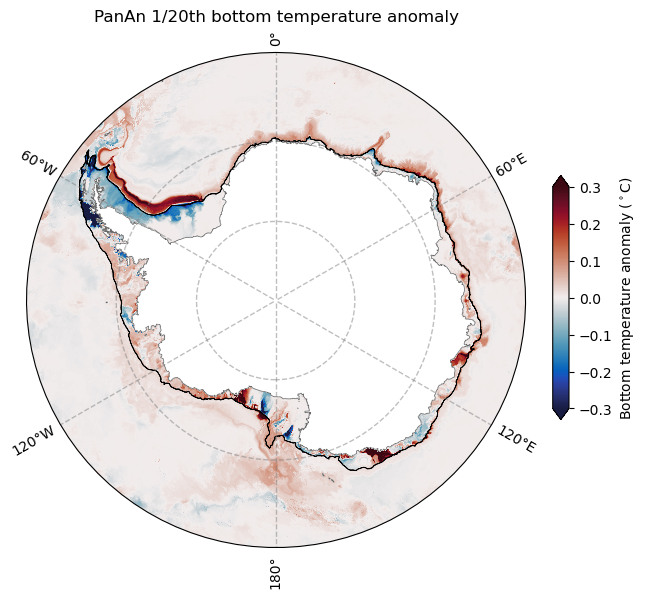

In [31]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAn 1/20th bottom temperature anomaly");

## Time Series

In [32]:
# Variable for landmask
saltC = cont['so']
saltM = melt['so']

In [33]:
# Correcting area
areaC_corr = areaC*saltC.isel(time=0,z_l=0)*0 +1
areaM_corr = areaM*saltM.isel(time=0,z_l=0)*0 +1

In [34]:
areaC_corr

<xarray.DataArray (yh: 1066, xh: 7200)> Size: 31MB
dask.array<add, shape=(1066, 7200), dtype=float32, chunksize=(563, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
    z_l      float64 8B 0.5413
    time     object 8B 2001-01-16 12:00:00

In [37]:
bottemp_cont_shelf = bottemp_cont.where(shelf_mask == 0)
bottemp_pert_shelf = bottemp_melt.where(shelf_mask == 0)

In [38]:
# Spatial average
bottemp_cont_time = (areaC_corr * bottemp_cont_shelf).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
bottemp_pert_time = (areaM_corr * bottemp_pert_shelf).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/array/core.py:5097: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/array/core.py:5097: PerformanceWarning: Increasing number of chunks by factor of 60
  result = blockwise(


In [39]:
bottemp_cont_time

<xarray.DataArray (time: 120)> Size: 960B
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l       float64 8B 0.5413
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    variable  <U2 8B 'so'

In [40]:
bottemp_cont_time = bottemp_cont_time.load()
bottemp_pert_time = bottemp_pert_time.load()

In [41]:
bottemp_anom_time = bottemp_pert_time - bottemp_cont_time
bottemp_anom_time = bottemp_anom_time.load()

Text(0.5, 1.0, 'PanAn 1/20th Time Series of Bottom Temperature on Shelf')

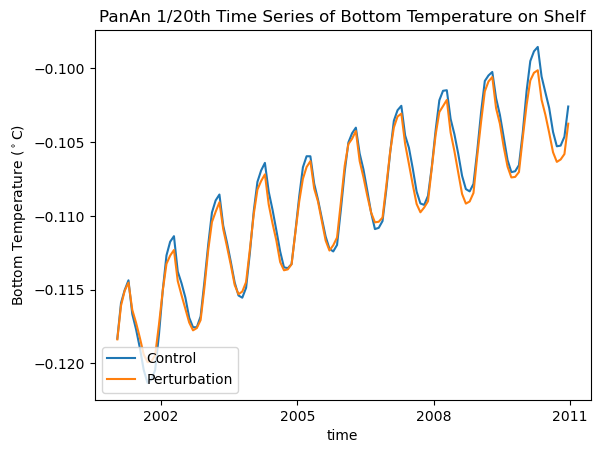

In [42]:
bottemp_cont_time.plot(label="Control")
bottemp_pert_time.plot(label="Perturbation")
plt.ylabel("Bottom Temperature ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("PanAn 1/20th Time Series of Bottom Temperature on Shelf")

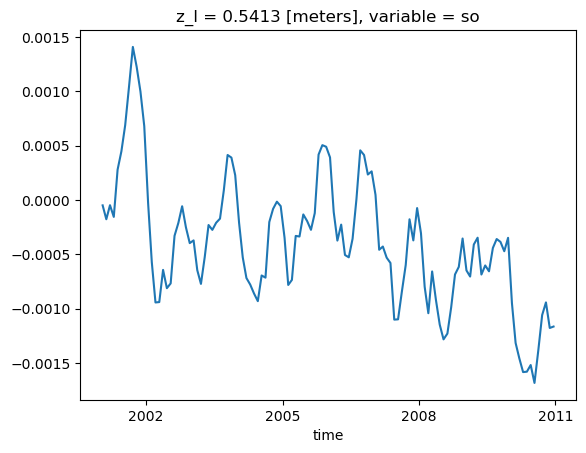

In [43]:
bottemp_anom_time.plot()

In [44]:
bottemp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan005.nc')

## Between model comparison

In [4]:
pan005_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan005.nc', chunks = 'auto')
pan01_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan01.nc', chunks = 'auto')
acc_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_access.nc', chunks = 'auto')

In [5]:
pan01_bottemp_anom_new = pan01_bottemp_anom.to_series()

In [6]:
acc_bottemp_anom_new = acc_bottemp_anom.to_series()

In [7]:
pan005_bottemp_anom_new = pan005_bottemp_anom.to_series()

In [8]:
import pandas as pd

In [9]:
# Slice 1910–1919 and 2001–2010
pan005_bottemp_anom_new = pan005_bottemp_anom_new['2001-01-01':'2010-10-16']
pan01_bottemp_anom_new = pan01_bottemp_anom_new['2001-01-01':'2010-10-16']
acc_bottemp_anom_new = acc_bottemp_anom_new['1910-01-16':'1919-12-16']

# Reset index to normalized months
pan005_bottemp_anom_new.index = range(1, len(pan005_bottemp_anom_new)+1)
pan01_bottemp_anom_new.index = range(1, len(pan01_bottemp_anom_new)+1)
acc_bottemp_anom_new.index = range(1, len(acc_bottemp_anom_new)+1)

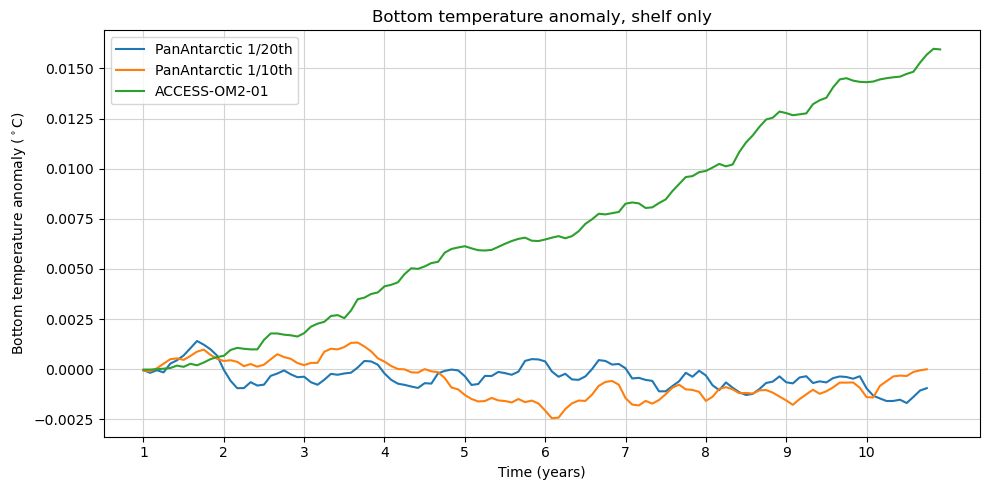

In [10]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(pan005_bottemp_anom_new.index, pan005_bottemp_anom_new.values, label='PanAntarctic 1/20th')
plt.plot(pan01_bottemp_anom_new.index, pan01_bottemp_anom_new.values, label='PanAntarctic 1/10th')
plt.plot(acc_bottemp_anom_new.index, acc_bottemp_anom_new.values, label='ACCESS-OM2-01')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.title('Bottom temperature anomaly, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()